# Exploration and Processing

Once the data has been prepared and linked to a master file, this master file can be acceded by everybody in the team. This file is the starting point for the exploration and processing of the data.

In [1]:
import numpy as np
import xdas as xd

In [2]:
# load previously saved master files
da = xd.open_dataarray("outputs/singlecable.nc")
dc = xd.open_datacollection("outputs/multicable.nc")

## Selection

Xdas both provide index base selection (`.isel`) and labeled based selection (`.sel`).

Below an examples to get a chunk of 4000 samples chunk starting at a given date and time:

In [3]:
starttime = "2023-11-03T12:26:40"
nsamples = 4000
da = da.sel(time=slice(starttime, None))  # everything after starttime
da = da.isel(time=slice(None, nsamples))  # first nsamples samples
da.to_netcdf("outputs/event.nc")

## Visualization

Because DataArray objects are self-described (they encapsulate both the data an its related metadata), plotting your DataArray is a one line job:

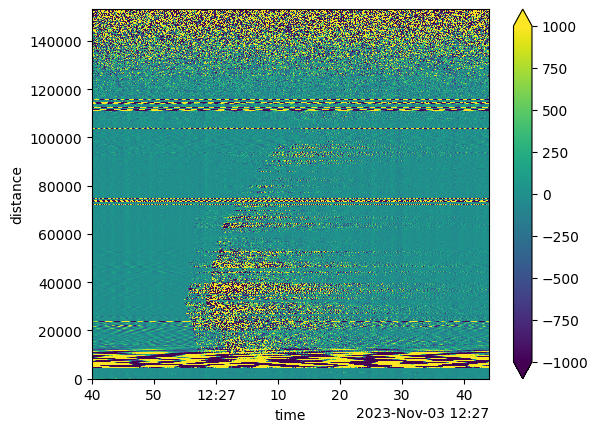

In [4]:
da.plot(x="time", vmin=-1000, vmax=1000)

## Processing

DataArray can be processed without having to extract the underlying N-dimensional array. Most numpy functions can be applied while preserving metadata. Xdas also wraps a large subset of numpy and scipy function by adding coordinates handling. You mainly need to replace axis arguments by dim ones and to provides dimensions by name and not by position.

### Basic processing

You can apply most numpy functions to a data array. Xdas also have its own implementations that work by labels. You can also manipulate data arrays objects as regular arrays, Xdas will check that dimensions and coordinates are consistent.

In [5]:
# Numpy functions
squared = np.square(da)
mean = xd.mean(da, "time")
std = da.std("distance")

# Arithmetics
squared = da * da
common_mode_removal = da - da.mean("distance")

### Scipy functions

In [6]:
import xdas.signal as xs

Most scipy function from the signal and fft submodule have been implemented. The Xdas function are multithreaded. A parallel keyword argument can be passed to most of them to indicate the number of cores to use.

Bellow an example of spatial and temporal decimation:

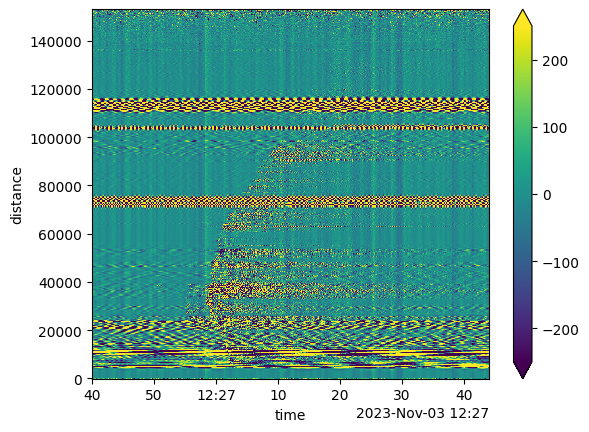

In [7]:
decimated = xs.decimate(
    da, 16, ftype="fir", dim="distance", parallel=None
)  # all cores by default
decimated = xs.decimate(
    decimated, 4, ftype="iir", dim="time", parallel=8
)  # height cores

decimated.plot(x="time", vmin=-250, vmax=250)

Here how to compute a FK diagram. Note that the DataArray object can be used to represent any number and kind of dimensions:

In [8]:
import xdas.fft as xfft

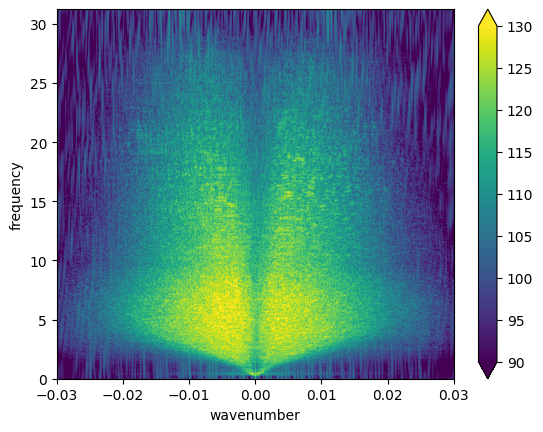

In [9]:
fk = da.sel(distance=slice(30000, 70000))
fk = xs.taper(fk, dim="distance")
fk = xs.taper(fk, dim="time")
fk = xfft.rfft(fk, dim={"time": "frequency"})  # rename "time" -> "frequency"
fk = xfft.fft(fk, dim={"distance": "wavenumber"})  # rename "distance" -> "wavenumber"
fk = 20 * np.log10(np.abs(fk))
fk.plot(interpolation="antialiased", vmin=90, vmax=130, xlim=(-0.03, 0.03))

### Convert strain to displacement

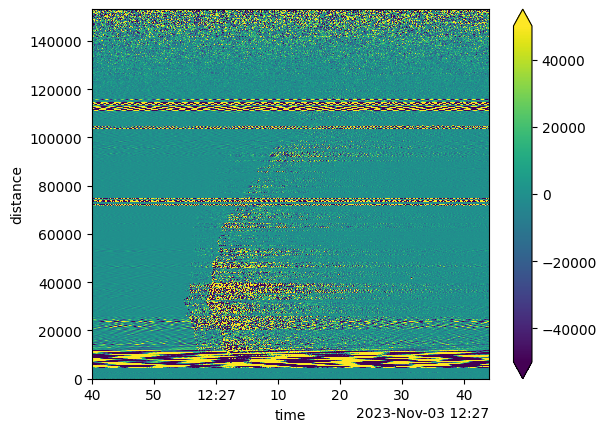

In [10]:
# Convert to displacement
deformation = xs.integrate(da, dim="distance")
displacement = xs.sliding_mean_removal(deformation, wlen=1000.0)

displacement.plot(x="time", yincrease=True, vmin=-50000, vmax=50000)